In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

import Model
import utils
import config
importlib.reload(Model)


class TransferLearningTrainer:
    def __init__(self, config):
        self.default_path = config.default_path
        self.classes = config.classes
        self.dataset = config.dataset
        self.info = config.Info

        self.train_ratio = 0.5
        self.set_epoch = 50
        self.set_batch_size = 256
        self.model_name = "TL_Model_increment"

        self.init_acc_all = []
        self.prev_acc_all = []
        self.trained_acc_all = []
        self.X_test_prev_all = []
        self.y_test_prev_all = []

    def train_initial_model(self, path):
        feature_set, labels = utils.get_dataset(path, self.classes, show_labels=False)
        X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, ratio=self.train_ratio)

        model = Model.Original_model_V1(X_train.shape[1:])
        history, model = Model.Train_model(
            model, X_train, y_train, X_test, y_test,
            self.set_epoch, self.set_batch_size, self.model_name,
            set_verbose=0, save_model_set=True
        )

        acc = model.evaluate(X_test, y_test, verbose=0)[1]
        self.init_acc_all.append(0.2)  # Dummy initial value for consistency
        self.prev_acc_all.append(acc)
        self.trained_acc_all.append(acc)
        self.X_test_prev_all = X_test
        self.y_test_prev_all = y_test

    def adapt_model(self, path, plot_learning_curve):
        feature_set, labels = utils.get_dataset(path, self.classes, show_labels=False)
        X_train, y_train, X_test, y_test = utils.split_data(feature_set, labels, self.train_ratio)

        model = load_model(f'{self.model_name}.keras')
        init_test_loss, init_test_acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"\nInitial Test Accuracy: {init_test_acc*100:.2f}%")

        history, adapted_model = Model.Train_model(
            model, X_train, y_train, X_test, y_test,
            self.set_epoch, self.set_batch_size, self.model_name,
            set_verbose=0, save_model_set=True
        )

        if plot_learning_curve:
            utils.visualize_history(history)

        self.X_test_prev_all = np.concatenate((self.X_test_prev_all, X_test), axis=0)
        self.y_test_prev_all = np.concatenate((self.y_test_prev_all, y_test), axis=0)

        prev_acc = adapted_model.evaluate(self.X_test_prev_all, self.y_test_prev_all, verbose=0)[1]
        max_test_acc = np.max(history.history['val_accuracy'])
        acc_diff = (max_test_acc - init_test_acc) * 100

        print(f"Accuracy Improvement: {acc_diff:.2f}%")
        print("\t ===> Positive" if acc_diff > 0 else "\t ===> Negative")

        self.init_acc_all.append(init_test_acc)
        self.prev_acc_all.append(prev_acc)
        self.trained_acc_all.append(max_test_acc)

    def run(self, plot_learning_curve=False):
        for idx, session in enumerate(self.dataset):
            print(f"\n{'='*43}\nDataset {idx+1}/{len(self.dataset)} - Session {session}\n{'='*43}")
            path = os.path.join(self.default_path, session, 'raw/')
            if idx == 0:
                self.train_initial_model(path)
            else:
                self.adapt_model(path, plot_learning_curve)

        return self.init_acc_all, self.trained_acc_all, self.prev_acc_all

    def plot_results(self, baseline_csv_path, baseline2_csv_path):
        baseline = pd.read_csv(baseline_csv_path)
        baseline2 = pd.read_csv(baseline2_csv_path)

        plt.figure(figsize=(15, 8))
        plt.title('Training from scratch every time', fontsize=15)
        plt.plot(self.info, self.init_acc_all, marker='o', label='Untrained model on current data', linestyle='--')
        plt.plot(self.info, self.prev_acc_all, marker='o', label='Model trained + tested on accumulated data')
        plt.plot(self.info, self.trained_acc_all, marker='o', label='Model trained + tested on current split')
        plt.plot(self.info, baseline['Accuracy'] / 100, marker='^', label='Baseline (first session only)', color='red', linestyle='--')
        plt.plot(self.info, baseline2['Accuracy'] / 100, marker='^', label='Baseline - v2 (first session only)', linestyle='--')

        plt.ylim([0, 1])
        plt.xlabel('Date (Sessions)')
        plt.ylabel('Test Accuracy')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



Dataset 1/26 - Session Exp_2025-05-27/E8331D05289A/
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 84.79%
Maximum validation accuracy : 92.7%

Dataset 2/26 - Session Exp_2025-06-18/E9AD0E7DCC2B/

Initial Test Accuracy: 83.99%
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 79.88%
Maximum validation accuracy : 84.02%
Accuracy Improvement: 0.02%
	 ===> Positive

Dataset 3/26 - Session Exp_2025-06-20-v1/E9AD0E7DCC2B/

Initial Test Accuracy: 83.02%
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 76.41%
Maximum validation accuracy : 84.19%
Accuracy Improvement: 1.16%
	 ===> Positive

Dataset 4/26 - Session Exp_2025-06-20-v2/E9AD0E7DCC2B/

Initial Test Accuracy: 84.56%
Start Training (total epochs: 50)...
Finish Training! (Model is saved)
Maximum training accuracy : 79.45%
Maximum validation accuracy : 84.98%
Accuracy Improvement: 0.42%
	 

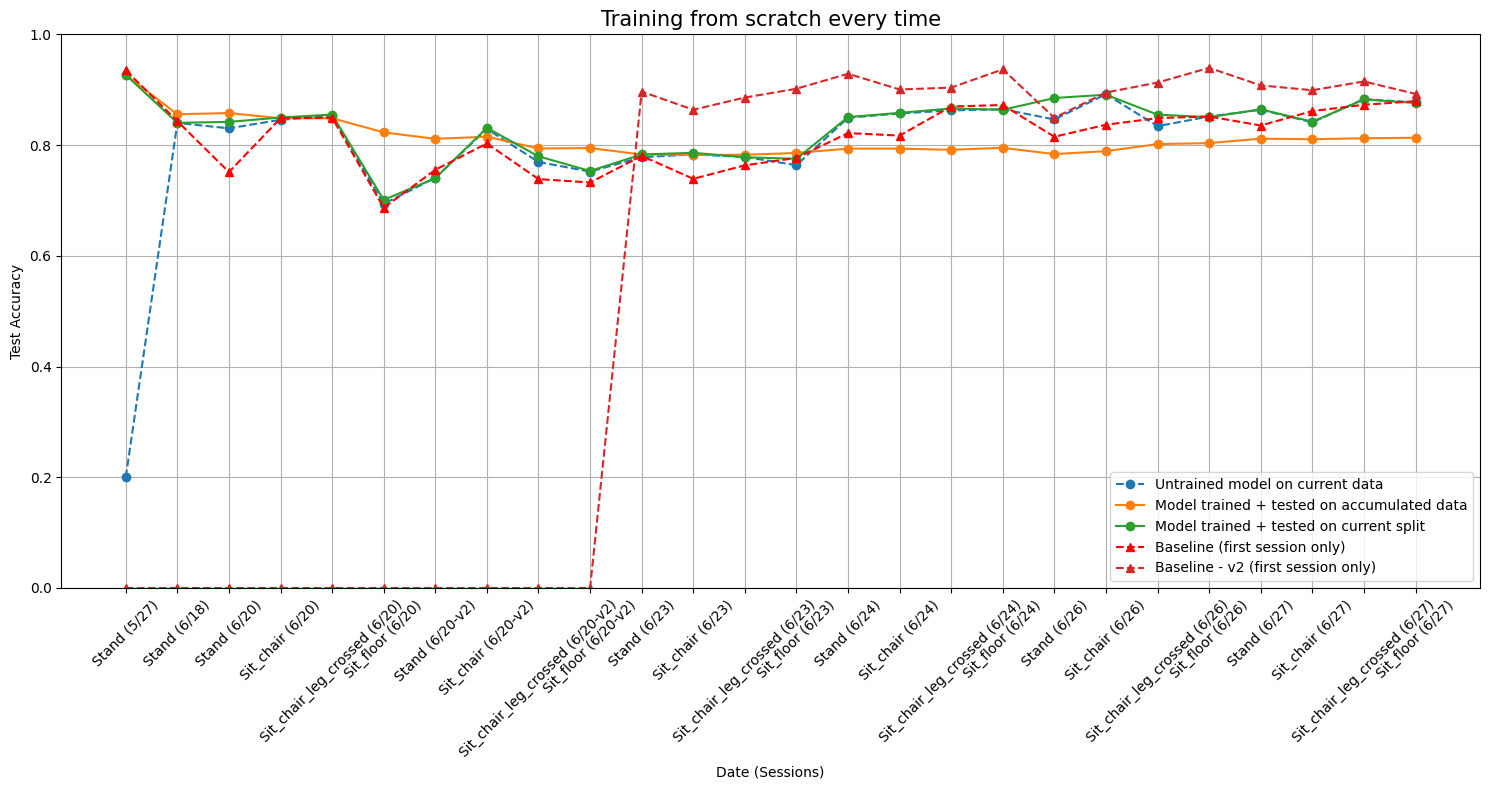

Average of acc without training this data (init; unseen) - incrementally trained model with previous datasets: 79.92%
Average of acc using previous test data after training (with increment): 83.18%
Average of acc using current test data after training (with increment): 81.18%


In [5]:
if __name__ == "__main__":
    baseline1_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results.csv'
    baseline2_csv_path = 'C:/Users/hml76/PycharmProjects/Tremor_project_local/NCI_mindforce/github/Results/Baseline_results_train_with_10data.csv'

    tl_trainer = TransferLearningTrainer(config)
    Init_acc_all, Prev_acc_all, Trained_acc_all = tl_trainer.run(plot_learning_curve=False)   #True if want to see convergence for each session round
    tl_trainer.plot_results(baseline1_csv_path, baseline2_csv_path)

    for idx, x in enumerate([Init_acc_all, Prev_acc_all, Trained_acc_all]):
        if idx==0:
            print(f"Average of acc without training this data (init; unseen) - incrementally trained model with previous datasets: {np.mean(x)*100:.2f}%")
        elif idx==1:
            print(f"Average of acc using previous test data after training (with increment): {np.mean(x)*100:.2f}%")
        elif idx==2:
            print(f"Average of acc using current test data after training (with increment): {np.mean(x)*100:.2f}%")